# MAD Competition

Maximum differentiation (MAD) competition comes from a paper published in 2008 by Zhou Wang and Eero Simoncelli ([reprint](https://www.cns.nyu.edu/pub/lcv/wang08-preprint.pdf) from LCV website). In MAD Competition, the goal is to efficiently compare two competing perceptual metrics. Like the inputs for all synthesis methods in `plenoptic`, metrics operate on images and produce predictions related to perception. As originally conceived, the metrics in MAD competition are either similarity (e.g., SSIM) or distance (e.g., MSE) metrics: they take two images and return a scalar value that gives a perceptual similarity or distance. For distance metrics, the smaller this number is, the more perceptually similar the metric predicts they will be; for similarity metrics, the larger the number is, the more percpetually similar.

In `plenoptic`, a single instantiation of `MADCompetition` synthesizes a single image, holding the `fixed_metric` constant while either maximizing or minimizing `synthesis_metric`, depending on the value of `synthesis_target`. A full set of MAD competition images consists of four images, maximizing and minimizing each of the two metrics. For each pair of images, one metric predicts they are perceptually identical, while the other metric predicts they are as dissimilar as possible. This set therefore allows us to efficiently compare the two models.

In the paper, these images are generated by manually computing the gradients, projecting one gradient out of the other, and repeating until convergence was reached. This doesn't work as well in the general case, so we instead optimize using the following objective function:

$$t L_1(x, \hat{x}) + \lambda_1 [L_2(x, x+\epsilon) - L_2(x, \hat{x})]^2 + \lambda_2 \mathcal{B}(\hat{x})$$

where $t$ is 1 if `mad.synthesis_target` is `'min'` and -1 if it's `'max'`, $L_1$ is `mad.synthesis_metric`, $L_2$ is `mad.fixed_metric`, $x$ is `mad.reference_signal`, $\hat{x}$ is `mad.synthesized_signal`, $\epsilon$ is the initial noise, $\mathcal{B}$ is the quadratic bound penalty, $\lambda_1$ is `mad.metric_tradeoff_lambda` and $\lambda_2$ is `mad.range_penalty_lambda`.


That's the general idea, now let's explore how to use the `MADCompetition` class for generating these images

In [1]:
import plenoptic as po
import imageio
import torch
import pyrtools as pt
import matplotlib.pyplot as plt
import numpy as np
import warnings

%load_ext autoreload
%autoreload 2

## Basic usage

As with all our synthesis methods, we start by grabbing a target image and initalizing our models.

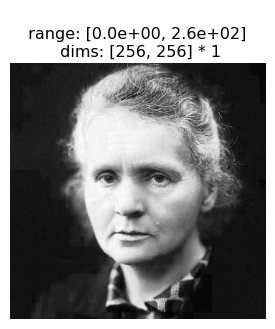

In [2]:
img = po.tools.data.load_images(['../data/256/curie.pgm'])
img = 255*img
po.imshow(img);

To start, we'll demonstrate MAD competition as described in the paper, using two metrics: SSIM (structural similarity index, described [here](https://www.cns.nyu.edu/pub/lcv/wang03-preprint.pdf)) and MSE (mean-squared error), implementations for both of which are found in `plenoptic.metric`. We use the weighted version of SSIM described in the MAD Competition paper, and images that range between 0 and 255, hence the keyword arguments passed to `ssim` below. Note also that we use `1-SSIM`: SSIM measures similarity (so that 0 means completely different and 1 means identical), but `MADCompetition` expects [metrics](https://en.wikipedia.org/wiki/Metric_(mathematics)), which return 0 if and only if the two inputs are identical.

In [3]:
model1 = lambda *args: 1-po.metric.ssim(*args, weighted=True, dynamic_range=255, pad='reflect')
model2 = po.metric.mse

To intitialize the method, we only need to specify the target image (as a 4d tensor, as returned by `load_images`), the two metrics, and the target. To start, we will hold MSE constant, while minimizing SSIM.

In [4]:
mad = po.synth.MADCompetition(img, synthesis_metric=model1, fixed_metric=model2, synthesis_target='min', allowed_range=(0, 255), initial_noise=10)

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/mad_competition.py:137: UserWarning: Since metric_tradeoff_lamda was None, automatically set to 0.0010000000474974513 to roughly balance metrics.
  warnings.warn("Since metric_tradeoff_lamda was None, automatically set"


At the most basic, all we need to do is call `mad.synthesize()`. Let's do that and then view the outcome (we set `store_progress=True` so that we store the synthesis progress as well as the final outcome). There are several additional arguments to `synthesize()` but none are required.

  0%|          | 0/200 [00:00<?, ?it/s]

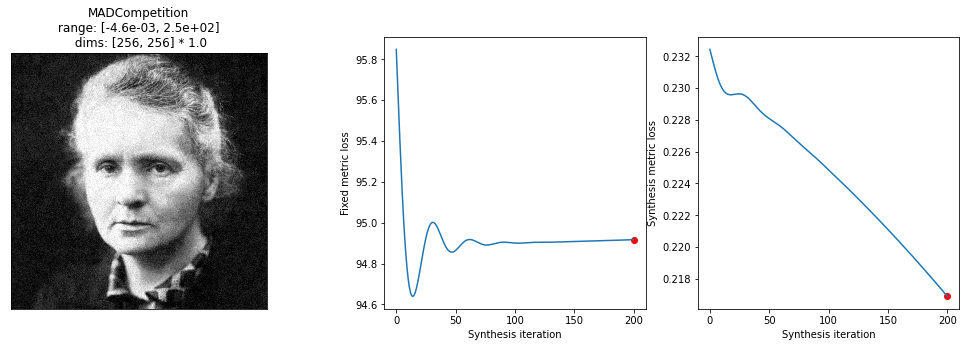

In [5]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad.synthesize(store_progress=True, max_iter=200)
fig = po.synth.mad_competition.plot_synthesis_status(mad)

We can see from the loss plot that SSIM's loss is decreasing, while MSE's is staying roughly constant. However, SSIM's loss hasn't decreased that much, so let's continue running synthesis!

To continue synthesis, we can simply call `mad.synthesize()` again. `store_progress` will need to have the same argument (and `optimizer` and `scheduler` will both need to be None), but we then pick up right where we left off.

  0%|          | 0/2000 [00:00<?, ?it/s]

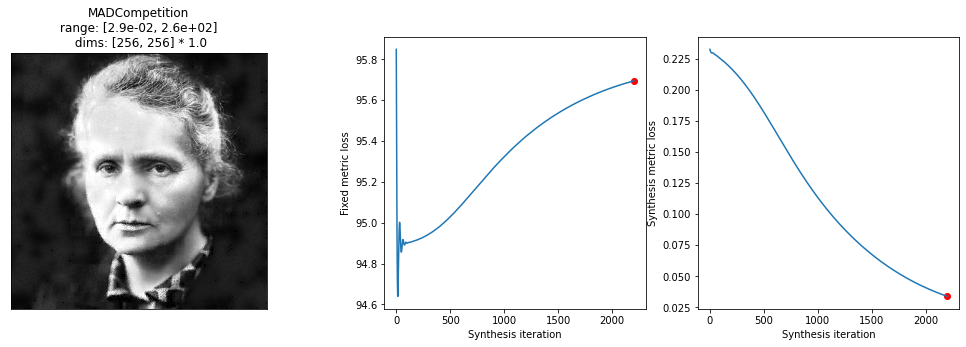

In [6]:
with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad.synthesize(store_progress=True, max_iter=2000)
fig = po.synth.mad_competition.plot_synthesis_status(mad)

We could continue this, but we see that we're starting to level off.

As described in the opening paragraph, a full set of MAD competition synthesized images consists of four images. In order to create the other images, we must create a new instance of `MADCompetition`. Let's do that for the other images now (we no longer set `store_progress=True` because we're not resuming synthesis):

/home/billbrod/Documents/plenoptic/plenoptic/synthesize/mad_competition.py:137: UserWarning: Since metric_tradeoff_lamda was None, automatically set to 0.0010000000474974513 to roughly balance metrics.
  warnings.warn("Since metric_tradeoff_lamda was None, automatically set"


  0%|          | 0/2000 [00:00<?, ?it/s]

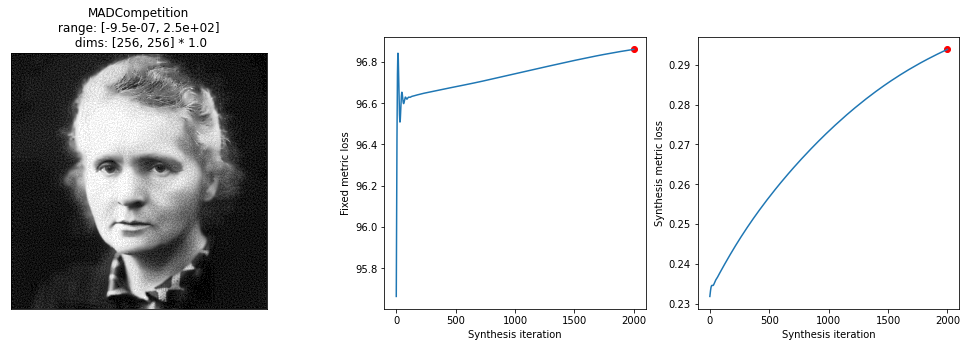

In [7]:
mad_ssim_max = po.synth.MADCompetition(img, synthesis_metric=model1, fixed_metric=model2, synthesis_target='max', allowed_range=(0, 255), initial_noise=10)

with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    mad_ssim_max.synthesize(max_iter=2000)
fig = po.synth.mad_competition.plot_synthesis_status(mad_ssim_max)

Holding SSIM constant while changing MSE is a bit trickier. SSIM is bounded between 0 and 1, so we want to pick a `metric_tradeoff_lambda` that does something similar for MSE. The largest MSE for each pixel will either be the difference between that pixel value and 0 or that pixel value and 255, so we create the image `torch.max(img, 255*torch.ones_like(img)-img)`. The square and sum of this is the largest possible MSE for this image and any other image of this size bounded between 0 and 255. If we used this as our lambda, the MSE in our objective function will be bounded between 0 and 1. In practice, if we do that, the image doesn't change at all -- the penalty is so large that we're unable to change MSE. So we divide that number (which is roughly `3e9`) by `1e-3` -- there's no principled reason for that number, but after playing around with several values, it seems to work reasonably well. We also increase the learning rate.

  0%|          | 0/2000 [00:00<?, ?it/s]

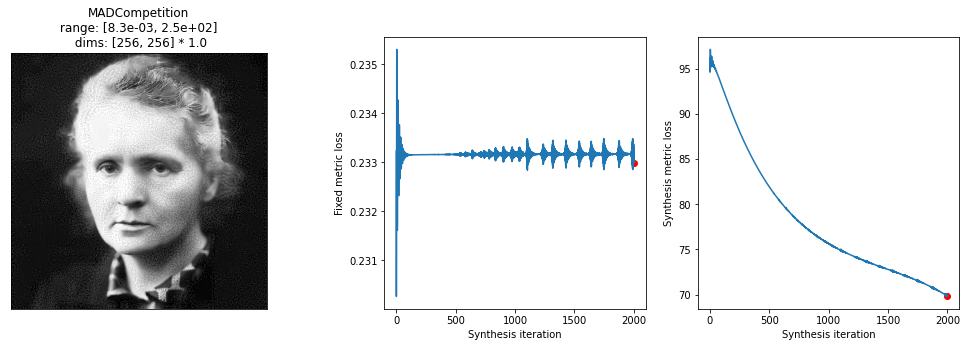

In [8]:
mad_mse_min = po.synth.MADCompetition(img, synthesis_metric=model2, fixed_metric=model1, synthesis_target='min', allowed_range=(0, 255), initial_noise=10, 
                                      metric_tradeoff_lambda=1e-3*torch.max(img, 255*torch.ones_like(img) - img).norm(2).pow(2))

with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    # we want a larger learning rate here, because the metric_tradeoff_lambda  is so high.
    opt = torch.optim.Adam([mad_mse_min.synthesized_signal], lr=.1)
    mad_mse_min.synthesize(max_iter=2000, optimizer=opt)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_min)

Maximizing MSE has the same issue; after playing around with it, we use a slightly larger `metric_tradeoff_lambda` than above.

In general, finding an appropriate hyperparameter here will require some consideration on the part of the user and some testing of different values.

  0%|          | 0/2000 [00:00<?, ?it/s]

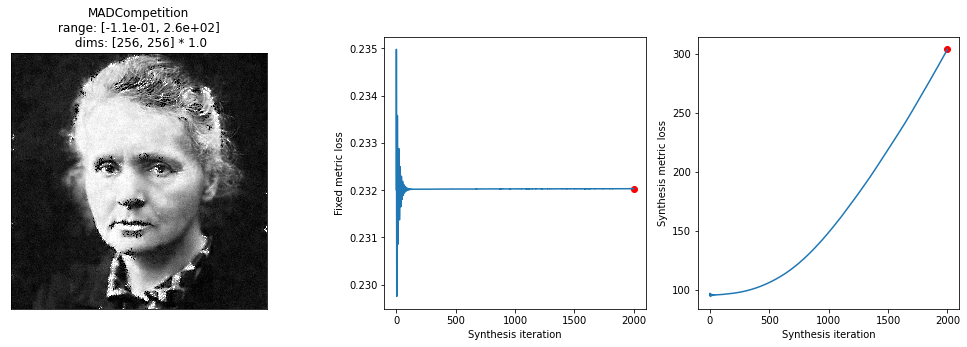

In [9]:
mad_mse_max = po.synth.MADCompetition(img, synthesis_metric=model2, fixed_metric=model1, synthesis_target='max', allowed_range=(0, 255), initial_noise=10, 
                                      metric_tradeoff_lambda=1e-2*torch.max(img, 255*torch.ones_like(img) - img).norm(2).pow(2))

with warnings.catch_warnings():
    # we suppress the warning telling us that our image falls outside of the (0, 255) range.
    warnings.simplefilter('ignore')
    # we want a larger learning rate here, because the metric_tradeoff_lambda  is so high.
    opt = torch.optim.Adam([mad_mse_max.synthesized_signal], lr=.1, amsgrad=True)
    mad_mse_max.synthesize(max_iter=2000, optimizer=opt)
fig = po.synth.mad_competition.plot_synthesis_status(mad_mse_max)

The image above has increased the local contrast in different parts of the image, which SSIM generally doesn't care about but MSE does. For example, the collar, which in the original image is two different shades of gray, here is black and white. Similarly with the eyes, hair, and lips.

While above we displayed the synthesized image and the loss together, these are actually handled by two helper functions and can be called separately, as axes-level figures. They have additional arguments that may be worth playing around with:

<AxesSubplot:xlabel='Synthesis iteration', ylabel='Synthesis metric loss'>

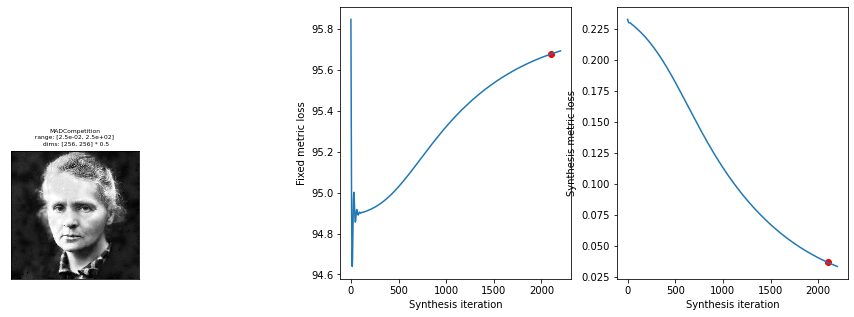

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 2]})
po.synth.mad_competition.display_synthesized_signal(mad, ax=axes[0], zoom=.5, iteration=-100)
po.synth.mad_competition.plot_loss(mad, axes=axes[1], iteration=-100)

We also provide helper functions to plot a full set of MAD images together, either displaying all their synthesized images or their losses (note that we're calling our metric `SDSIM` because it's now the structural *dis*-similarity):

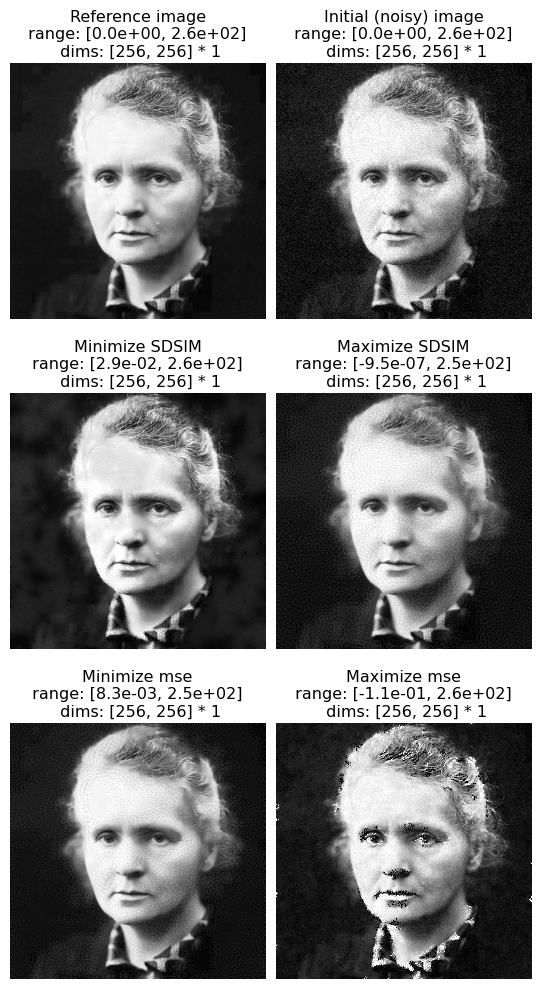

In [11]:
po.synth.mad_competition.display_synthesized_signal_all(mad, mad_mse_min, mad_ssim_max, mad_mse_max, 'SDSIM');

The top row shows the reference and initial images, our picture of Marie Curie and that same image plus some normally-distributed noise. The next row of images has the same MSE as the right image in the top row (when compared against the reference image), but different SDSIM values. The left image has the lowest SDSIM and is thus considered the best image, while the right image has the highest SDSIM and is thus considered the worst. The next row of images has the same SDSIM as the right image in the top, but different MSE values. The left has the lowest MSE and is thus considered the best, while the right has highest MSE and is thus considered the worst.

So MSE considers the first three images to be approximately equivalent in quality, while SDSIM considers the first image and the last two to be equivalent.

From the following plot, we can see that we generally manage to hold the fixed metric constant (dashed line for SDSIM in the right plot, solid line for MSE in the left) while increasing the target metric.

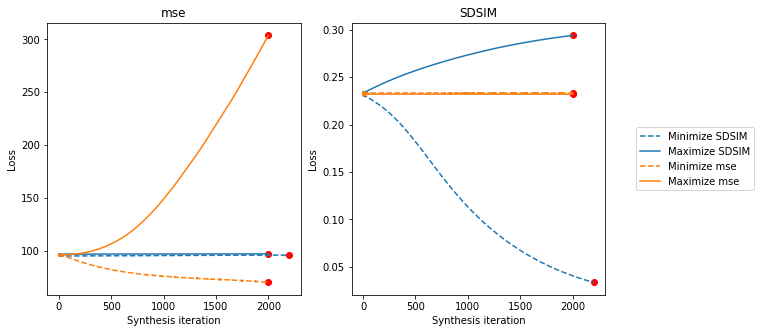

In [12]:
po.synth.mad_competition.plot_loss_all(mad, mad_mse_min, mad_ssim_max, mad_mse_max, 'SDSIM');